In [2]:
import numpy as np
from pydpmd.data import RigidBumpy, load
from pydpmd.plot import draw_particles_frame, create_animation, downsample
from correlation_functions import compute_msd, compute_shear_modulus, compute_rotational_msd, compute_pair_correlation_function, compute_vacf, compute_rotational_msd
from pydpmd.calc import run_binned, run_binned_ragged, fused_msd_kernel, TimeBins, LagBinsExact, LagBinsLog, LagBinsLinear, LagBinsPseudoLog, requires_fields
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os
import re
from tqdm import tqdm
from scipy.optimize import minimize
import pandas as pd
def obj_func(b, x, y):
    return np.sum((x + b - y) ** 2)

def get_relaxation_time(f, t, max_t=None):
    if max_t is None:
        max_t = max(t)
    mask = t <= max_t
    tau = np.interp(1 / np.e, f[mask][::-1], t[mask][::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def fit_power_left(x, y, xc_min=None, xc_max=None, n_grid=2001, min_pts=5):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    if x.size != y.size:
        raise ValueError("x and y must have same length.")
    # need positive y for log
    m = np.isfinite(x) & np.isfinite(y) & (y > 0)
    x, y = x[m], y[m]
    if x.size < min_pts:
        raise ValueError("Not enough positive-y points.")

    # build a simple xc grid
    xmin, xmax = x.min(), x.max()
    span = xmax - xmin if xmax > xmin else 1.0
    if xc_min is None: xc_min = xmax - 0.2 * span
    if xc_max is None: xc_max = xmax + 0.2 * span
    if not (np.isfinite(xc_min) and np.isfinite(xc_max) and xc_max > xc_min):
        raise ValueError("Bad xc bounds.")
    xc_grid = np.linspace(xc_min, xc_max, int(n_grid))

    best = {'SSE': np.inf, 'xc': None, 'n': None, 'A': None}
    for xc in xc_grid:
        sel = x < xc
        if sel.sum() < min_pts:
            continue
        u = np.log(xc - x[sel])        # ln(xc - x)
        v = np.log(y[sel])             # ln y
        # linear fit: v = alpha + n * u
        p = np.polyfit(u, v, 1)        # p[0]=n, p[1]=alpha
        vhat = p[0] * u + p[1]
        sse = np.sum((v - vhat) ** 2)
        if sse < best['SSE']:
            best['SSE'] = float(sse)
            best['xc']  = float(xc)
            best['n']   = float(p[0])
            best['A']   = float(np.exp(p[1]))
    if best['xc'] is None:
        raise RuntimeError("No admissible xc produced a fit. Widen xc bounds.")
    return best

In [7]:
dt = 1e-2
T = 1e-6
for i, root in enumerate([
    # '/home/mmccraw/dev/data/10-15-25/new-shear-modulus/'
    # '/home/mmccraw/dev/data/10-15-25/new-shear-modulus-dilute/'
    '/home/mmccraw/dev/data/10-15-25/new-shear-modulus-full-range/'
]):
    break
values = {}
trial_id = 0
while True:
    data_path = os.path.join(root, f"trial-{trial_id}")
    if not os.path.exists(data_path):
        break
    trial_id += 1
    i = 0
    while True:
        path = os.path.join(data_path, f"shear_modulus_{i}.npz")
        if not os.path.exists(path):
            break
        data = np.load(path)

        # piece together the global id for each system
        minimization_path = os.path.join(data_path, f"minimization_{i}")
        if not os.path.exists(minimization_path):
            raise FileNotFoundError(f"Minimization file not found: {minimization_path}")
        try:
            minimization_data = load(minimization_path, location=['final', 'init'])
            minimization_data.calculate_mu_eff()
        except:
            break
        if i == 0:
            system_ids = np.arange(minimization_data.system_size.size)
            global_mu_eff = minimization_data.mu_eff[minimization_data.system_offset[:-1]]
            global_nv = minimization_data.n_vertices_per_particle[minimization_data.system_offset[:-1]]

        assert (np.sum(np.abs(global_mu_eff[system_ids] - data['mu_eff'])) == 0) and (np.sum(np.abs(global_nv[system_ids] - data['nv'])) == 0)


        G = data['shear_modulus']
        t = data['t'] * dt * np.sqrt(T)
        mu_eff = np.round(data['mu_eff'], 10)
        nv = data['nv']
        phi = np.round(data['packing_fraction'], 10)

        for j in range(G.shape[1]):
            mu = mu_eff[j]
            n = nv[j]
            if (mu, n) not in values:
                values[(mu, n)] = {}
            if (trial_id, system_ids[j]) not in values[(mu, n)]:
                values[(mu, n)][(trial_id, system_ids[j])] = []
            values[(mu, n)][(trial_id, system_ids[j])].append([G[:, j], t, phi[j]])
        i += 1

        # update the next iteration system ids (systems with more than the PE threshold are removed)
        avg_pe = minimization_data.pe_total / minimization_data.system_size
        system_ids = system_ids[avg_pe < 1e-15]

/tmp/ipykernel_1704887/1498039118.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[1].scatter(k[0], fit['xc'], c=cmap(norm(k[0])), marker='o')
/tmp/ipykernel_1704887/1498039118.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[2].scatter(k[0], -fit['n'], c=cmap(norm(k[0])), marker='o')


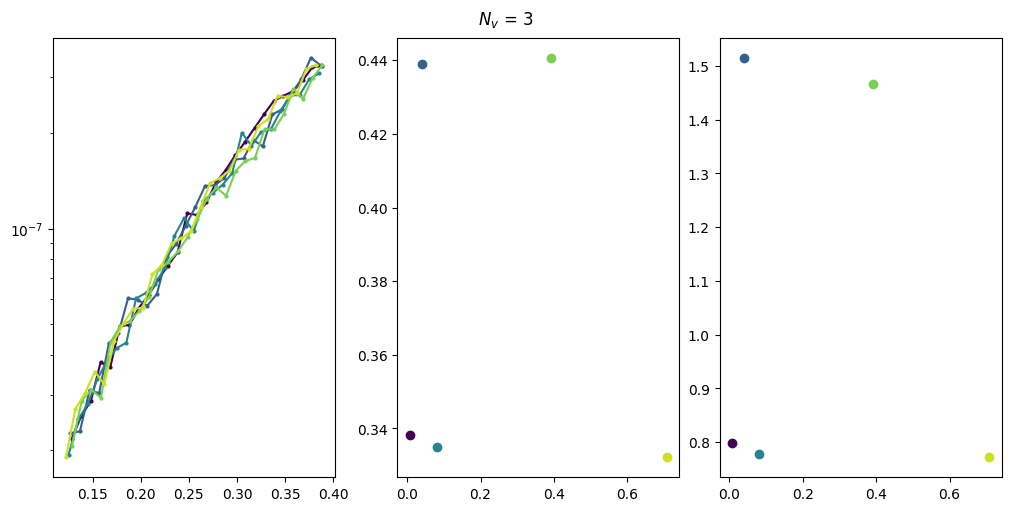

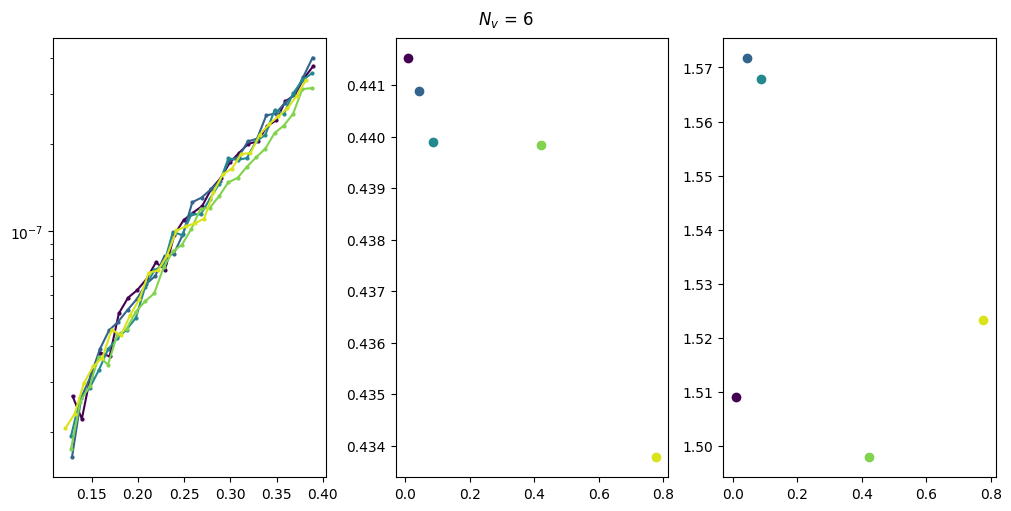

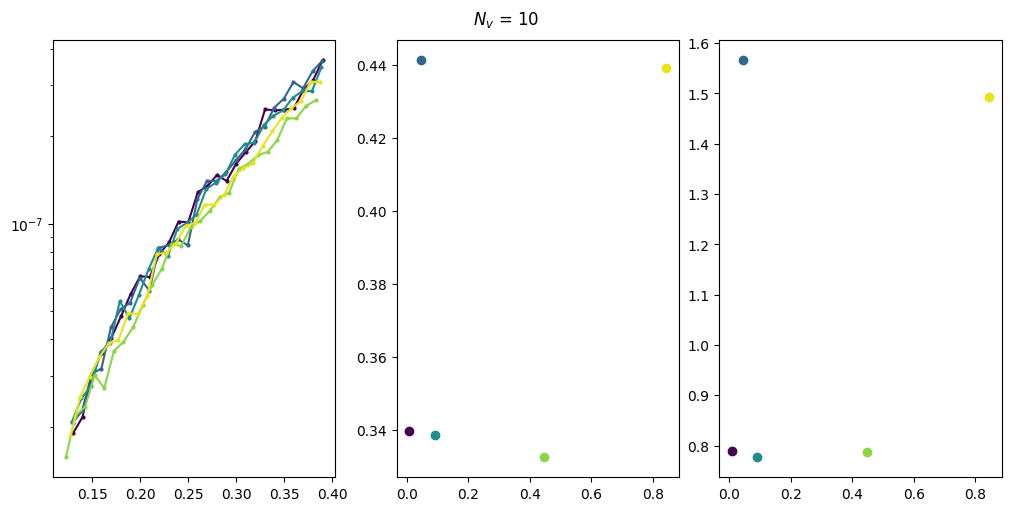

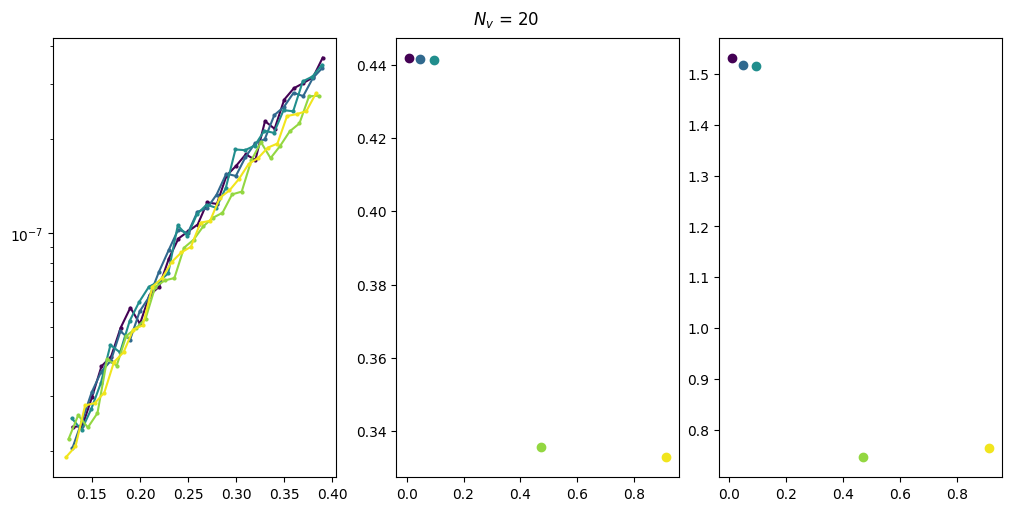

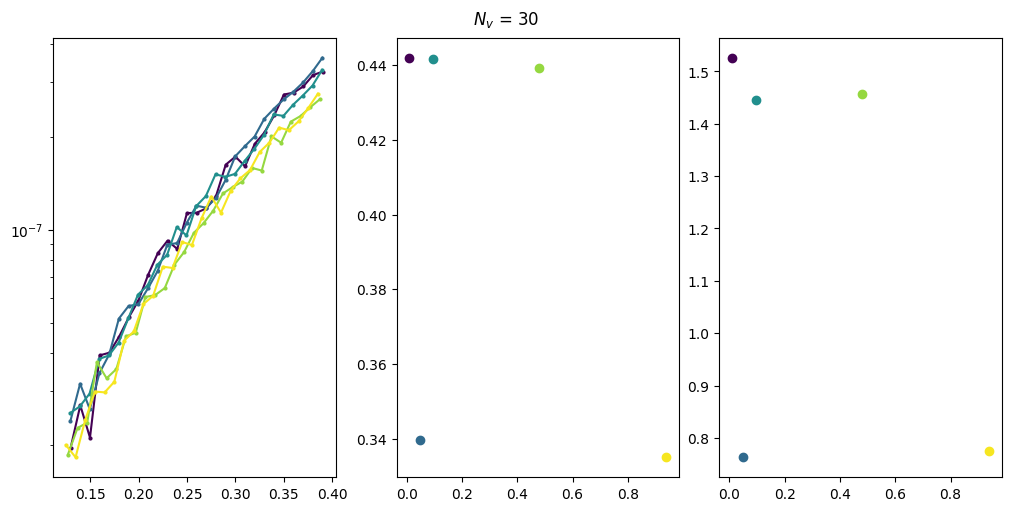

In [ ]:
norm = LogNorm(1e-2, 1e0)
cmap = plt.cm.viridis

for _nv in np.unique([_[1] for _ in values.keys()]):
    fig, ax = plt.subplots(1, 3, figsize=(10, 5), constrained_layout=True)
    for k in values.keys():
        if k[1] != _nv:
            continue
        delta_phi_list = []
        phi_list = []
        G_0_list = []
        tau_list = []
        eta_list = []
        for (trial_id, system_id), G_t_phi in values[k].items():
            # DO NOT INCLUDE THE LAST POINT IN THE DATA!
            G_0 = np.array([G[0] for G, t, phi in G_t_phi[:-1]])
            tau = np.array([get_relaxation_time(G / G[0], t, max_t=0.5 * max(t)) for G, t, phi in G_t_phi[:-1]])
            eta = G_0 * tau
            phi = np.array([phi for G, t, phi in G_t_phi[:-1]])
            # plt.scatter(phi, eta, s=1)
            
            delta_phi_list.extend(max(phi) - phi)
            phi_list.extend(phi)
            G_0_list.extend(G_0)
            tau_list.extend(tau)
            eta_list.extend(eta)

        G_0_list = np.array(G_0_list)
        tau_list = np.array(tau_list)
        eta_list = np.array(eta_list)
        delta_phi_list = np.array(delta_phi_list)
        phi_list = np.array(phi_list)
        
        # bin the data by delta_phi
        bins = np.linspace(min(delta_phi_list), max(delta_phi_list), 100)
        bin_indices = np.digitize(delta_phi_list, bins)
        G_0_binned = []
        tau_binned = []
        eta_binned = []
        phi_binned = []
        for i in range(1, len(bins)):
            mask = bin_indices == i
            if sum(mask) > 0:
                G_0_binned.append(np.mean(G_0_list[mask]))
                tau_binned.append(np.mean(tau_list[mask]))
                eta_binned.append(np.mean(eta_list[mask]))
                phi_binned.append(np.mean(phi_list[mask]))
        G_0_binned = np.array(G_0_binned)
        tau_binned = np.array(tau_binned)
        eta_binned = np.array(eta_binned)
        phi_binned = np.array(phi_binned)
        delta_phi_binned = (bins[1:] + bins[:-1]) / 2

        fit = fit_power_left(phi_binned, eta_binned)
        # ax[0].plot(fit['xc'] - phi_binned, fit['A'] * np.abs(fit['xc'] - phi_binned) ** fit['n'], c=cmap(norm(k[0])), linestyle='--')

        # ax[0].plot(fit['xc'] - phi_binned, eta_binned, c=cmap(norm(k[0])), marker='o', markersize=2)
        ax[0].plot(phi_binned, eta_binned, c=cmap(norm(k[0])), marker='o', markersize=2)

        ax[1].scatter(k[0], fit['xc'], c=cmap(norm(k[0])), marker='o')
        ax[2].scatter(k[0], -fit['n'], c=cmap(norm(k[0])), marker='o')
    for a in ax:
        # a.set_xscale('log')
        pass
    ax[0].set_yscale('log')
    plt.suptitle(fr'$N_v$ = {_nv - 1}')
    plt.show()

In [8]:
def aggregate_shear_modulus_data(root, dt, T):
    values = {}
    trial_id = 0
    while True:
        data_path = os.path.join(root, f"trial-{trial_id}")
        if not os.path.exists(data_path):
            break
        trial_id += 1
        i = 0
        while True:
            path = os.path.join(data_path, f"shear_modulus_{i}.npz")
            if not os.path.exists(path):
                break
            data = np.load(path)

            G = data['shear_modulus']
            t = data['t'] * dt * np.sqrt(T)
            mu_eff = np.round(data['mu_eff'], 10)
            nv = data['nv']
            phi = np.round(data['packing_fraction'], 10)

            for j in range(G.shape[1]):
                mu = mu_eff[j]
                n = nv[j]
                if (mu, n) not in values:
                    values[(mu, n)] = {}
                if phi[j] not in values[(mu, n)]:
                    values[(mu, n)][phi[j]] = []
                values[(mu, n)][phi[j]].append([G[:, j], t])
            i += 1

    shear_modulus_data = {}
    for mu_n_key in values.keys():
        g_data, t_data, phi_data = [], [], []
        size = None
        max_phi = -np.inf
        for i, phi_key in enumerate(values[mu_n_key].keys()):
            g, t = np.mean(np.array(values[mu_n_key][phi_key], dtype=object), axis=0)
            g_data.append(g)
            t_data.append(t)
            phi_data.append(phi_key)
            if phi_key > max_phi:
                max_phi = phi_key
                size = np.array(values[mu_n_key][phi_key], dtype=object).shape[0]
        g_data = np.array(g_data).astype(float)
        t_data = np.array(t_data).astype(float)
        phi_data = np.array(phi_data).astype(float)
        shear_modulus_data[mu_n_key] = {'g': g_data, 't': t_data, 'phi': phi_data}
    return shear_modulus_data

In [9]:
shear_modulus_data = {}
dt = 1e-2
T = 1e-6
for i, root in enumerate([
    '/home/mmccraw/dev/data/10-15-25/new-shear-modulus/'
]):
    new = aggregate_shear_modulus_data(root, dt, T)
    shear_modulus_data.update(new)

/tmp/ipykernel_683501/2729695432.py:27: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax[3].scatter(mu_eff, fit['xc'], c=cmap(mu_eff_norm(mu_eff)), marker='o')


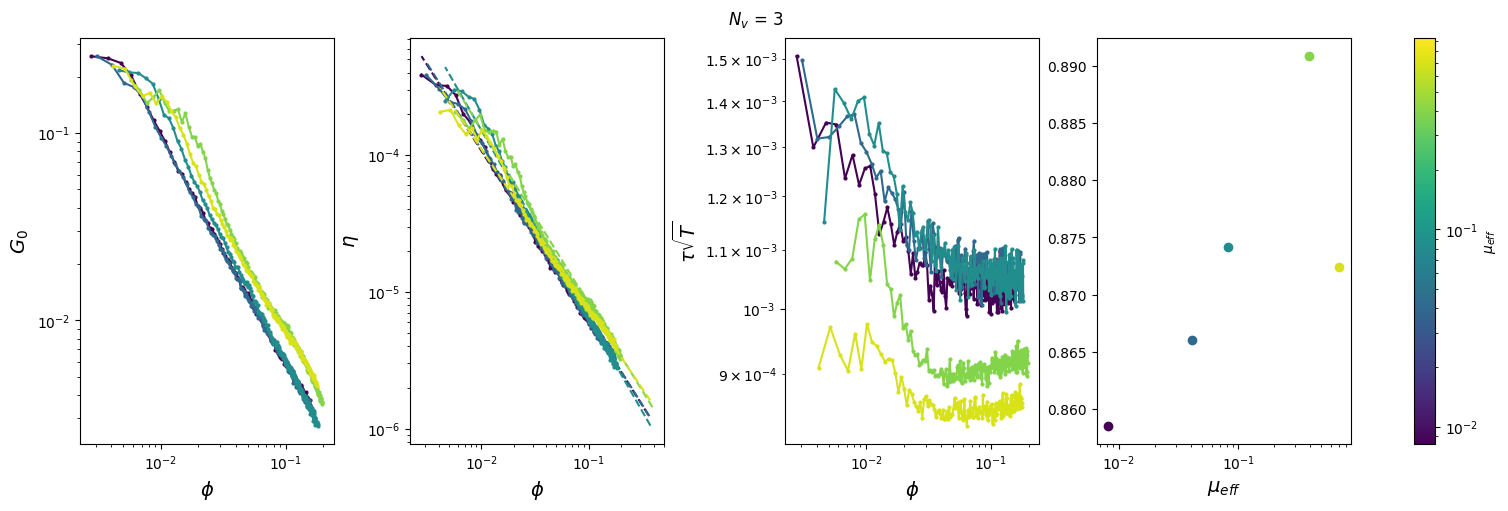

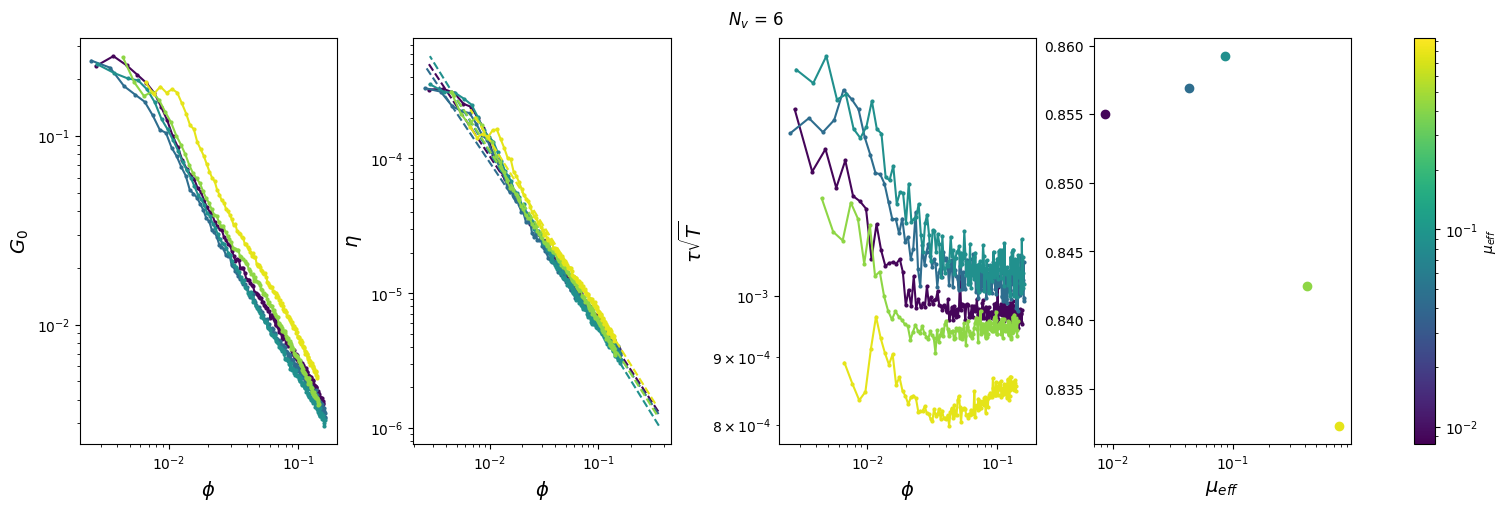

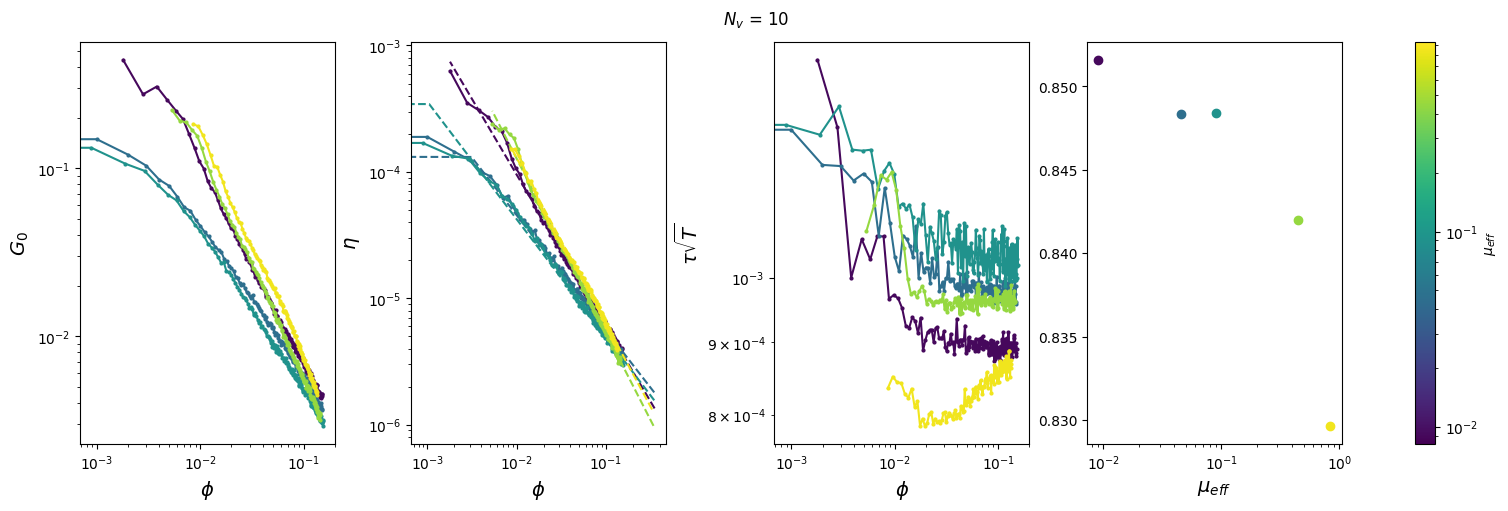

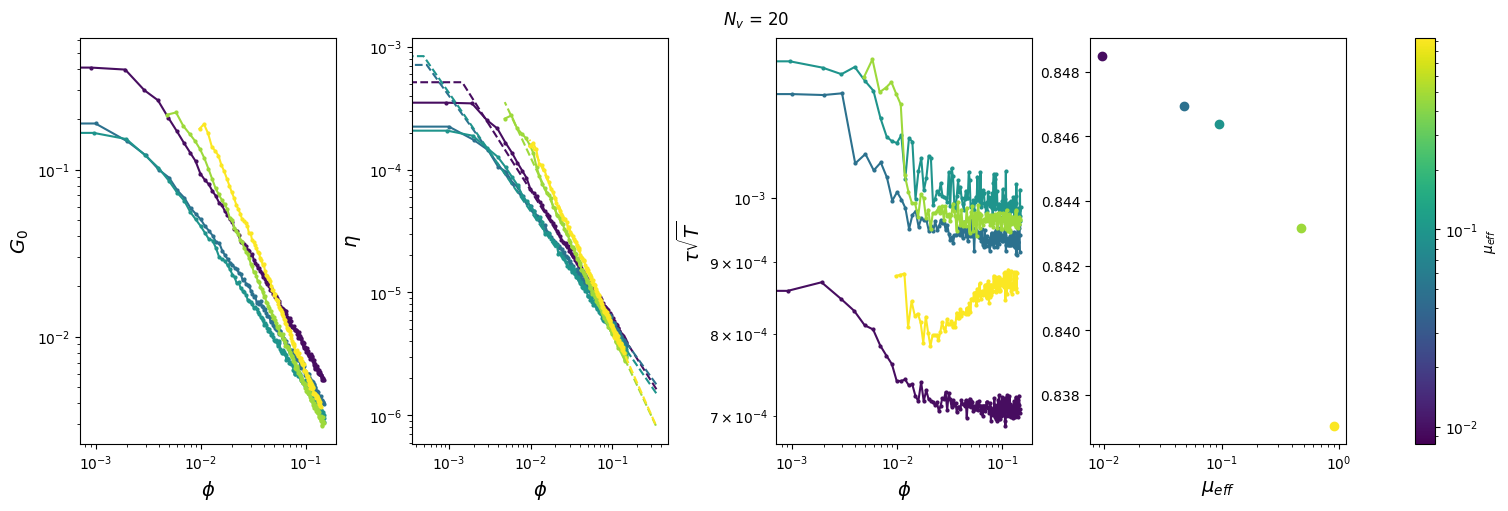

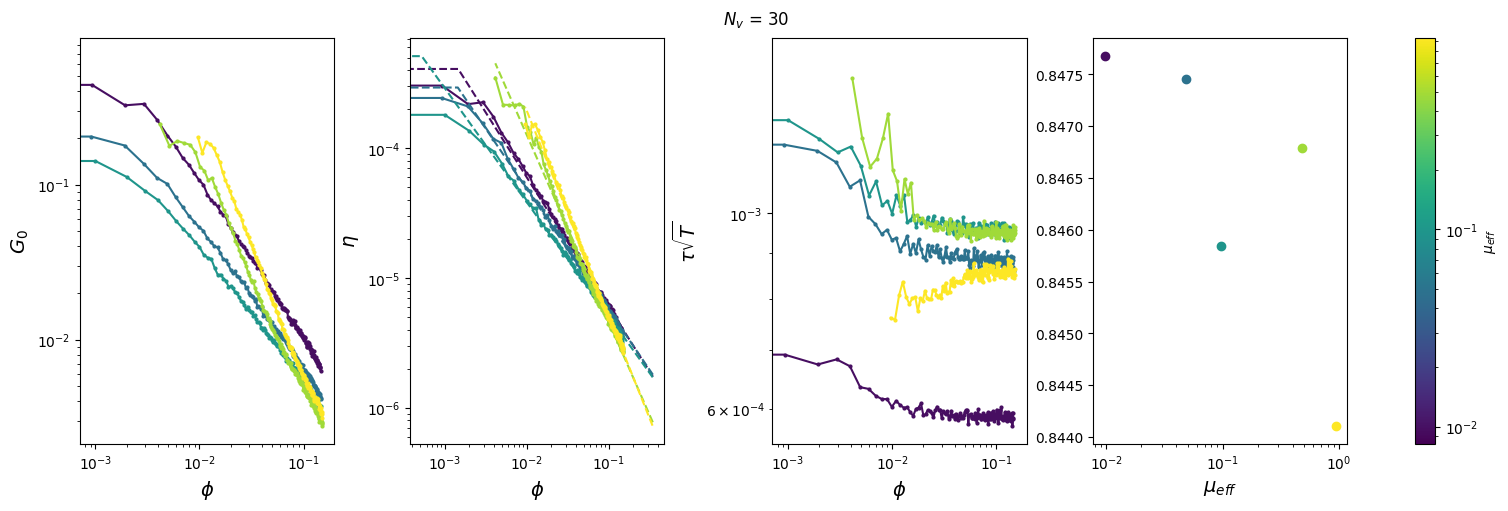

In [10]:
keys = list(shear_modulus_data.keys())
mu_eff_unique = np.unique(np.array(keys)[:, 0])
nv_unique = np.unique(np.array(keys)[:, 1])
mu_eff_norm = LogNorm(min(mu_eff_unique), max(mu_eff_unique))
cmap = plt.cm.viridis
for nv in nv_unique:
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), constrained_layout=True)

    for k in keys:
        if k[1] != nv:
            continue
        mu_eff = k[0]
        n = k[1]

        tau = np.array([get_relaxation_time(g / g[0], t) for g, t in zip(shear_modulus_data[k]['g'], shear_modulus_data[k]['t'])])
        G_0 = np.array([g[0] for g in shear_modulus_data[k]['g']])
        p = shear_modulus_data[k]['phi'].copy()

        fit = fit_power_left(p, G_0 * tau)

        ax[0].plot(fit['xc'] - p, G_0, c=cmap(mu_eff_norm(mu_eff)), marker='o', markersize=2)
        ax[1].plot(fit['xc'] - p, G_0 * tau, c=cmap(mu_eff_norm(mu_eff)), marker='o', markersize=2)
        ax[2].plot(fit['xc'] - p, tau, c=cmap(mu_eff_norm(mu_eff)), marker='o', markersize=2)

        p_plot = np.linspace(0.5, max(p), 100)
        ax[1].plot(fit['xc'] - p_plot, fit['A'] * np.abs(fit['xc'] - p_plot) ** fit['n'], c=cmap(mu_eff_norm(mu_eff)), linestyle='--')
        ax[3].scatter(mu_eff, fit['xc'], c=cmap(mu_eff_norm(mu_eff)), marker='o')

    for i, a in enumerate(ax):
        if i == 3:
            break
        a.set_yscale('log')
        a.set_xlabel(r'$\phi$', fontsize=14)
        a.set_xscale('log')
    ax[3].set_xscale('log')
    ax[3].set_xlabel(r'$\mu_{eff}$', fontsize=14)
    ax[0].set_yscale('log')
    ax[0].set_ylabel(r'$G_0$', fontsize=14)
    ax[1].set_ylabel(r'$\eta$', fontsize=14)
    # ax[1].set_ylim(3e-6, 3e-4)
    ax[2].set_ylabel(r'$\tau \sqrt{T}$', fontsize=14)
    plt.suptitle(fr'$N_v$ = {int(nv) - 1}')
    sm = plt.cm.ScalarMappable(norm=mu_eff_norm, cmap=cmap)
    sm.set_array(mu_eff_unique)
    cbar = plt.colorbar(sm, ax=ax, label=r'$\mu_{eff}$')
    plt.show()

# TODO:

- FINALIZE PLOTS

- REPEAT FOR DILUTE CASE